# 实现神经网络实例

In [1]:
#导入需要的包
import numpy as np
import torch

# 导入 pytorch 内置的 mnist 数据
from torchvision.datasets import mnist

#导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from tensorboardX import SummaryWriter

In [2]:
#设定一些超参数
train_batch_size = 64
test_batch_size = 128
num_epoches=10

## 下载并读取预处理之后的数据

In [3]:
#定义预处理函数tansforms.Compose()可以把一些转换函数组合在一起
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
 
#下载数据，并对数据进行预处理
train_data = mnist.MNIST('../数据', train=True, transform=transform,download=False)
test_data  = mnist.MNIST('../数据', train=False, transform=transform,download=False)


#得到一个生成器,批处理结构
train_loader = DataLoader(train_data,batch_size=train_batch_size,shuffle=True)
test_loader  = DataLoader(test_data ,batch_size=test_batch_size,shuffle=True)

#查看其中一个训练数据的大小
example = enumerate(train_loader)
i,(example_data,example_target) = next(example)

In [4]:
example_data.shape#64为批处理个数；1为通道数；图片长宽为28*28

torch.Size([64, 1, 28, 28])

In [5]:
example_data=example_data.view(example_data.size(0),-1)
print(example_data.shape)
print(len(train_loader))
print(example_data.shape[0])

torch.Size([64, 784])
938
64


## 构建模型

### 方法一
采用torhc.nn.Sequential()来构建网络层，使用起来就像搭积木一样。不过，这种方法每层的编码是默认的数字，不易区分。

In [6]:
class Net(nn.Module):
    def __init__(self,in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim,n_hidden_1),nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1,n_hidden_2),nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2,out_dim))
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = (self.layer3(x))
        return x

## 方法二
如果对每层定义一个名称，我们可以采用Sequential的一种改进方法。在Sequential的基础上，通过add_module()添加每一层，并且为每一层增加一个单独的名字。此外，还可以再Sequential基础上，通过字典的形式添加每一层，并且设置单独的层名称。下面是用字典的方式构建网络的实例代码。

In [7]:
class Net1(torch.nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.conv = torch.nn.Sequential(
            OrderedDict(
                [
                    ("conv1", torch.nn.Conv2d(3, 32, 3, 1, 1)),
                    ("relu1", torch.nn.ReLU()),
                    ("pool", torch.nn.MaxPool2d(2))
                ]
            ))

        self.dense = torch.nn.Sequential(
            OrderedDict([
                ("dense1", torch.nn.Linear(32 * 3 * 3, 128)),
                ("relu2", torch.nn.ReLU()),
                ("dense2", torch.nn.Linear(128, 10))
            ])
        )


In [8]:
#设定超参数lr和momentum
lr = 0.01
momentum = 0.9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")#实例化模型之前判断是否有GPU

#实例化模型
model = Net(28*28,300, 100, 10)
model.to(device)#若有GPU转到GPU上运行

#定义损失和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=lr, momentum=momentum)



## 定义损失和优化器

In [9]:
#定义损失和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=lr, momentum=momentum)

## 训练模型

In [10]:
#初始化：训练集损失，训练集准确度，测试集损失，测试集准确度。
losses= []
acces= []
eval_losses = []
eval_acces = []

#创建文件夹训练损失（用以保存训练损失图）
writer=SummaryWriter(log_dir='..\数据\练习三（训练损失）',comment='train-loss')

#开始训练
for epoch in range(num_epoches):
    train_loss = 0
    train_acc  = 0
    #设置成训练模式
    model.train()
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.9
        print(optimizer.param_groups[0]['lr'])
    for img,label in train_loader:
        img=img.to(device)#若有GPU转到GPU上运行
        label=label.to(device)#若有GPU转到GPU上运行
    
        img=img.view(img.size(0),-1)#img形状从原来的64*1*28*28变为64*784
        
        #前向传播
        out=model(img)
        loss=criterion(out, label)#loss为一个batch_size的损失
        
        #反向传播
        optimizer.zero_grad()#防止在迭代过程中梯度累计，先将梯度清零。
        loss.backward()
        optimizer.step()#执行梯度更新
        
        #记录一个epoch的损失
        train_loss+=loss.item()#.item()方法 是得到一个元素张量里面的元素值。
                               #train_loss为一个epoch的所有batch_size损失之和。
        
        #保存loss的数据和epoch数值
        writer.add_scalar('Train',train_loss/len(train_loader),epoch)#横轴为平均损失，纵轴为第几个epoch
        
        #记录分类准确度
        _,pred = out.max(1)#max(-1)中的-1表示按照最后一个维度（行）求最大值.并返回行方向上最大值对应的索引
                            #max(1)表示行方向的最大值和行方向最大值的索引。_表示最大值，pred表示索引。
        num_correct = (pred == label).sum().item()#num_correct为一个batch_size分类正确的数量
        acc = num_correct /img.shape[0]#acc为此batch_size的准确率
        train_acc += acc     #train_acc为一个epoch中所有batch_size的准确率之和。
        
    losses.append(train_loss/len(train_loader))#len(train_loader)为一个epoch中batch_size的个数
                                             #一个epoch的损失除以batch_size的个数得到平均每个batch_size的误差
    acces.append(train_acc/len(train_loader))#一个epoch的准确率除以batch_size个数得到平均每个batch_size的准确率。
    
    
    #在测试集上检验效果
    eval_loss=0
    eval_acc =0
    model.eval() #net.eval() 将模型改为预测模式
    for img,label in test_loader:
        
        img = img.to(device)
        label=label.to(device)
        
        img=img.view(img.size(0),-1)
        out=model(img)
        loss=criterion(out,label)
        
        #记录误差
        eval_loss+=loss.item()
        
        #记录准确率
        _,pred = out.max(1)
        num_correct=(pred==label).sum().item()
        acc = num_correct/img.shape[0]
        eval_acc +=acc
    eval_losses.append(eval_loss/len(test_loader))
    eval_acces.append(eval_acc/len(test_loader))
    print('epoch:{},Train Loss:{:.4f},Train Acc:{:.4f},Test Loss:{:.4f},Test Acc:{:.4f}'
         .format(epoch,train_loss/len(train_loader),train_acc/len(train_loader)
                 ,eval_loss/len(test_loader),eval_acc/len(test_loader)))
        

0.009000000000000001
epoch:0,Train Loss:0.2277,Train Acc:0.9349,Test Loss:0.0975,Test Acc:0.9704
epoch:1,Train Loss:0.0874,Train Acc:0.9734,Test Loss:0.0722,Test Acc:0.9784
epoch:2,Train Loss:0.0610,Train Acc:0.9816,Test Loss:0.0695,Test Acc:0.9779
epoch:3,Train Loss:0.0463,Train Acc:0.9854,Test Loss:0.0664,Test Acc:0.9783
epoch:4,Train Loss:0.0341,Train Acc:0.9895,Test Loss:0.0601,Test Acc:0.9805
0.008100000000000001
epoch:5,Train Loss:0.0255,Train Acc:0.9925,Test Loss:0.0579,Test Acc:0.9810
epoch:6,Train Loss:0.0197,Train Acc:0.9945,Test Loss:0.0548,Test Acc:0.9831
epoch:7,Train Loss:0.0174,Train Acc:0.9953,Test Loss:0.0514,Test Acc:0.9846
epoch:8,Train Loss:0.0137,Train Acc:0.9963,Test Loss:0.0514,Test Acc:0.9853
epoch:9,Train Loss:0.0125,Train Acc:0.9967,Test Loss:0.0557,Test Acc:0.9833


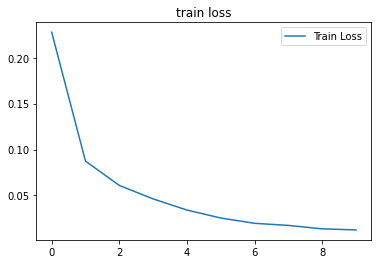

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
#plt.plot(np.arange(len(eval_losses)), eval_losses)
#plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.legend(['Train Loss'], loc='upper right')

# 优化器的比较